<a href="https://colab.research.google.com/github/rubygitflow/Sentence-extraction/blob/master/University_of_Artificial_Intelligence_NLP_HomeWork_10_Pro_Sentence_extraction_Ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP.Lesson 10.Sentence extraction.Ru. LDA Preprocessing + RNN Training

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
from numba import jit # декоратор numba, который будет оптимизировать наш код

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk

import os

# Импортируем для подсчета времени 
import time 
from datetime import datetime

In [3]:
# Сервисная функция Печати даты
def print_now():
  return datetime.today().strftime("%Y-%m-%d %H:%M:%S") # 2020-04-05 00:18:00

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

In [6]:
!pip install pyldavis

     |████████████████████████████████| 1.6MB 5.2MB/s 
     |████████████████████████████████| 552kB 25.0MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=ad74d3580e113690670c2af4073875bd745ee9f549d22ee2c710d42b84190c1b
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=d4832b5f88ba2919c442172e3823d1dc3349713e261e70c947b0ca49738fcd03
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


In [7]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [8]:
!pip install pymorphy2==0.8

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 7.1MB 5.2MB/s 


In [9]:
import pymorphy2

In [10]:
!pip install xlsxwriter

     |████████████████████████████████| 153kB 4.6MB/s 


In [47]:
from collections import Counter

In [103]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from sklearn.model_selection import train_test_split

# Read Dataset

In [11]:
path='/content/drive/My Drive/Базы/NLP/'

In [23]:
# @jit(nopython=True)
def read_med_dataset(path, folder):
# Парсим .xlsx
  filepath = path + folder
  file_name = os.listdir(filepath)
  print(file_name[:5], 'Всего примеров {} '.format(len(file_name)))

  data = pd.read_excel(filepath+file_name[0], header= None, names=['Cat', 'Data'])
  d = []
  ods = 0
  c = 0
  k = 0
  for i in file_name:
    try:
      df_ = pd.read_excel(filepath+i, header= None, names=['Cat', 'Data']) 
      df_.dropna(how="all", inplace=True)
      df_['paper_idx'] = c

      # Есть ошибки в разметке. Лишние строки, лишние столбцы индексов. Избавимся от этого.

      if len(df_) != 6:     
        df_ = pd.read_excel(filepath+i, header= None, names=['Cat', 'Data'])
        df_.drop(columns=0, axis=1, inplace=True)
        df_.dropna(how="all", inplace=True)
        df_['paper_idx'] = c
      
      data = data.merge(df_, how = "outer")
      c += 1
      if c % 100 == 0:
        k += 1
        print('batch {} is ready'.format(k))
    except: # В датасете были файлы с неправильным разрешением (например, .ods), мы их оставим для тестовой выборки, не будем их трогать.
      ods +=1
      print('Something went wrong! batch = {}, c = {}, file_name = {}, ods = {}'.format(k, c, i, ods)) 
    
  print('В датасет добавлено {} файлов' .format(c))
  if ods>0:
    print('В датасете {} файлов в неправильном расширении' .format(ods))
  return data

In [24]:
# print(print_now())
# start_time = time.time()
# data = read_med_dataset(path,'Мед статьи 1/')
# print('Общее время: {:.2f}s'.format(time.time() - start_time))

2020-09-25 15:15:14
['Наш опыт применения соноэластографии простаты при заболеваниях предстательной железы.xlsx', 'Негативное влияние антиретровирусной терапии на показатели спермограммы у мужчин, инфицированных ВИЧ.xlsx', 'Недостаточность кровотока в артериях вертебрально-базилярной системы при синдроме передней лестничной мышцы.xlsx', 'НЕИНВАЗИВНАЯ ДИАГНОСТИКА И РЕЗУЛЬТАТЫ ИНТЕРВЕНЦИОННОГО ЛЕЧЕНИЯ АР~ОЙ СИСТЕМЫ НЕИНВАЗИВНОГО ПОВЕРХНОСТНОГО КАРТИРОВАНИЯ «АМИКАРД 01К».xlsx', 'Неинтервенционное (наблюдательное) исследование применения лекарс~мсулозин (Профлосин®) у пациентов с доброкачественной гиперплазией.xlsx'] Всего примеров 2005 
batch 1 is ready
batch 2 is ready
batch 3 is ready
batch 4 is ready
batch 5 is ready
batch 6 is ready
batch 7 is ready
Something went wrong! batch = 7, c = 797, file_name = 237.xlsx, ods = 1
batch 8 is ready
batch 9 is ready
batch 10 is ready
batch 11 is ready
batch 12 is ready
batch 13 is ready
batch 14 is ready
batch 15 is ready
batch 16 is ready

In [25]:
# len(data)

12012

In [27]:
# data.head(30)

,Cat,Data,paper_idx
0,Название,Наш опыт применения соноэластографии простаты ...,0
1,Абстракт,Цель – оценить возможности соноэластографии (С...,0
2,Введение,Заболевания предстательной железы (ПЖ) занимаю...,0
3,Материалы и методы,Работа по изучению возможностей СЭГ в диагност...,0
4,Обсуждение,NaN,0
5,Результаты,На основе ранее проведенных исследований были...,0
6,Название,Негативное влияние антиретровирусной терапии н...,1
7,Абстракт,Цель исследования – оценить показатели спермог...,1
8,Введение,В настоящее время около 37 млн человек в мире ...,1
9,Материалы и методы,Проведено проспективное исследование «случай –...,1


In [28]:
# print(print_now())
# start_time = time.time()
# data = data.merge(read_med_dataset(path,'Мед статьи 2/'), how = "outer")
# print('Общее время: {:.2f}s'.format(time.time() - start_time))

2020-09-25 15:16:41
['285.xlsx', '286.xlsx', '907.xlsx', '909.xlsx', '287.xlsx'] Всего примеров 1649 
batch 1 is ready
batch 2 is ready
Something went wrong! batch = 2, c = 285, file_name = Влияние применения L-триптофана на динамику когнитивных функций в комплексной терапии задержек психоречевого развития у детей.xlsx, ods = 1
batch 3 is ready
Something went wrong! batch = 3, c = 376, file_name = Нарушение водно-электролитного обмена у пациентов с метаболическим синдромом.xlsx, ods = 2
batch 4 is ready
Something went wrong! batch = 4, c = 417, file_name = Роль и КТ- и МР-признаки фокального полнокровия в развитии и течении инсульта.xlsx, ods = 3
Something went wrong! batch = 4, c = 465, file_name = Эффективность психофармакотерапии у пациентов с расстройствами де~а в зависимости от некоторых особенностей догоспитального периода.xlsx, ods = 4
batch 5 is ready
Something went wrong! batch = 5, c = 528, file_name = 324.xlsx, ods = 5
Something went wrong! batch = 5, c = 536, file_name

In [29]:
# len(data)

21784

In [34]:
# # Добавим колонку с значением длины 'Data'
# s_len= []
# for i in data.Data.str.split():
#   try:
#     s_len.append(len(i))
#   except:
#     s_len.append(0)
# data['len'] = s_len
# data.head(30)

,Cat,Data,paper_idx,len
0,Название,Наш опыт применения соноэластографии простаты ...,0,9
1,Абстракт,Цель – оценить возможности соноэластографии (С...,0,205
2,Введение,Заболевания предстательной железы (ПЖ) занимаю...,0,408
3,Материалы и методы,Работа по изучению возможностей СЭГ в диагност...,0,375
4,Обсуждение,NaN,0,0
5,Результаты,На основе ранее проведенных исследований были...,0,508
6,Название,Негативное влияние антиретровирусной терапии н...,1,11
7,Абстракт,Цель исследования – оценить показатели спермог...,1,400
8,Введение,В настоящее время около 37 млн человек в мире ...,1,411
9,Материалы и методы,Проведено проспективное исследование «случай –...,1,473


In [36]:
# data.to_excel('/content/drive/My Drive/Базы/NLP/Мед_статьи.xlsx', engine='xlsxwriter')

In [14]:
data = pd.read_excel(path+'Мед_статьи.xlsx')

In [15]:
len(data)

21784

In [16]:
data.head(30)

,Unnamed: 0,Cat,Data,paper_idx,len
0,0,Название,Наш опыт применения соноэластографии простаты ...,0,9
1,1,Абстракт,Цель – оценить возможности соноэластографии (С...,0,205
2,2,Введение,Заболевания предстательной железы (ПЖ) занимаю...,0,408
3,3,Материалы и методы,Работа по изучению возможностей СЭГ в диагност...,0,375
4,4,Обсуждение,NaN,0,0
5,5,Результаты,На основе ранее проведенных исследований были...,0,508
6,6,Название,Негативное влияние антиретровирусной терапии н...,1,11
7,7,Абстракт,Цель исследования – оценить показатели спермог...,1,400
8,8,Введение,В настоящее время около 37 млн человек в мире ...,1,411
9,9,Материалы и методы,Проведено проспективное исследование «случай –...,1,473


In [17]:
# Nan поменяем на тег, что бы при преобразовани в строку не было ошибок.
data.fillna('<nan>', inplace = True)
data

,Unnamed: 0,Cat,Data,paper_idx,len
0,0,Название,Наш опыт применения соноэластографии простаты ...,0,9
1,1,Абстракт,Цель – оценить возможности соноэластографии (С...,0,205
2,2,Введение,Заболевания предстательной железы (ПЖ) занимаю...,0,408
3,3,Материалы и методы,Работа по изучению возможностей СЭГ в диагност...,0,375
4,4,Обсуждение,<nan>,0,0
...,...,...,...,...,...
21779,21779,Абстракт,Зачастую у пациентов с симптомами типичной СС ...,1631,110
21780,21780,введение,Самой распространённой формой ИБС является СС:...,1631,294
21781,21781,материалы и\n методы,"Из числа 16839 пациентов, включённых в «Регист...",1631,300
21782,21782,обсуждение,В отличие от группы сравнения большинство паци...,1631,799


In [18]:
# Посмотрим на длину предложений по каждой категории
name_len         = [data.len[i] for i in range(0,data.shape[0], 6)]
abstr_len        = [data.len[i] for i in range(1,data.shape[0], 6)]
introduction_len = [data.len[i] for i in range(2,data.shape[0], 6)]
materials_len    = [data.len[i] for i in range(3,data.shape[0], 6)]
discussion_len   = [data.len[i] for i in range(4,data.shape[0], 6)]
result_len       = [data.len[i] for i in range(5,data.shape[0], 6)]

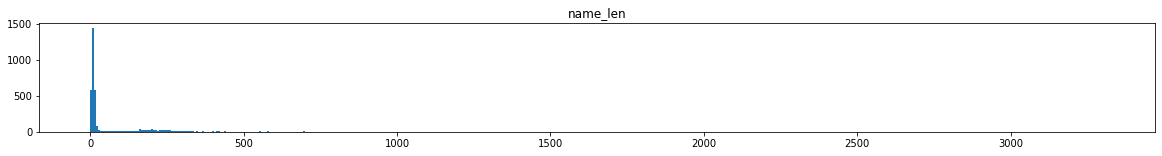

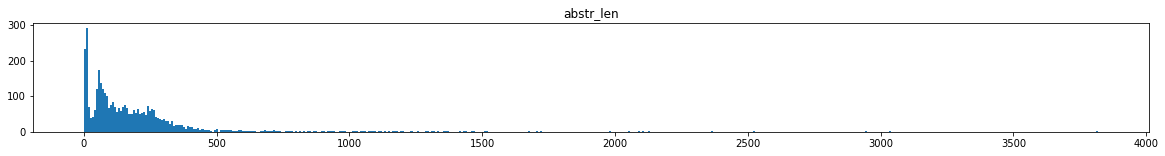

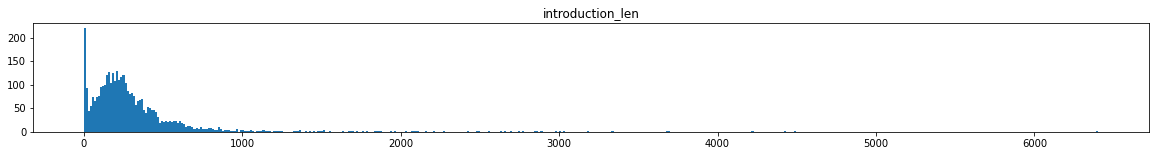

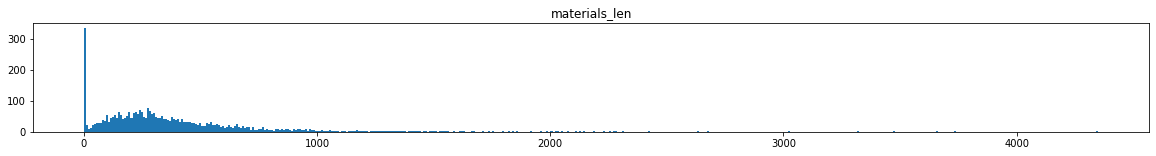

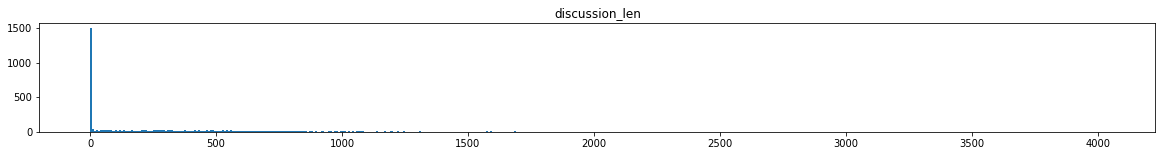

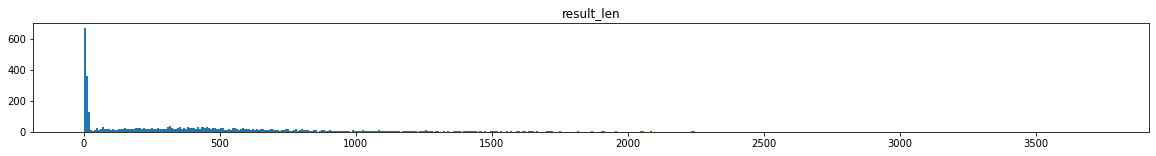

In [19]:
plt.figure(figsize = (20,2))
plt.hist(name_len, bins = 500)
plt.title('name_len')
plt.show()
plt.figure(figsize = (20,2))
plt.hist(abstr_len, bins = 500)
plt.title('abstr_len')
plt.show()
plt.figure(figsize = (20,2))
plt.hist(introduction_len, bins = 500)
plt.title('introduction_len')
plt.show()
plt.figure(figsize = (20,2))
plt.hist(materials_len, bins = 500)
plt.title('materials_len')
plt.show()
plt.figure(figsize = (20,2))
plt.hist(discussion_len, bins = 500)
plt.title('discussion_len')
plt.show()
plt.figure(figsize = (20,2))
plt.hist(result_len, bins = 500)
plt.title('result_len')
plt.show()

## Lemmatization

In [20]:
X=data.Data

In [21]:
X[0]

'Наш опыт применения соноэластографии простаты при заболеваниях предстательной железы'

In [22]:
morph = pymorphy2.MorphAnalyzer()

In [31]:
# @jit(nopython=False)
def lemmatization(texts, allowed_postags=['NOUN', 'ADJS', 'VERB', 'ADVB']): 
  texts_out=[]
  for ww in texts:
    texts=[]
    for w in str(ww).split(' '):
      p = morph.parse(w)[0]    
      if p.tag.POS in allowed_postags:
        texts.append(p.normal_form)  
    texts_out.append(texts) 
  return texts_out

In [32]:
print(print_now())
start_time = time.time()
sequences = lemmatization(X)
print('Общее время: {:.2f}s'.format(time.time() - start_time))

2020-09-25 16:02:30
Общее время: 1575.07s


In [50]:
sequences[1]

['цель',
 'возможность',
 'соноэластография',
 'диагностик',
 'заболевание',
 'место',
 'алгоритм',
 'диагностика',
 'заболевание',
 'пж.\nматериал',
 'обследование',
 'выполнение',
 'работа',
 'пациент',
 'быть',
 'группы.\nпациент',
 'подозрение',
 'рак',
 'будущее',
 'быть',
 'биопсия',
 'простата',
 'подтверждение',
 'рак',
 'быть',
 'группа',
 'составить',
 'пациент',
 'гиперплазия',
 'группа',
 'войти',
 'явление',
 'пациент',
 'заболевание',
 'быть',
 'уровень',
 'биопсия',
 'пациент',
 'быть',
 'проведено\nсопоставление',
 'картина',
 'данные',
 'участок',
 'заставлять',
 'процесс',
 'морфологически',
 'диагноз',
 '«рак',
 'пациент',
 'картина',
 'соответствовать',
 'быть',
 'методика',
 'диагностика',
 'заболевание',
 'тип',
 'картирование',
 'позволять',
 'диагностик',
 'процесс',
 'пж.\nсэг',
 'улучшать',
 'диагностик',
 'стадирование',
 'иметь',
 'значимость',
 'сравнение',
 'томография']

In [35]:
len(sequences)

21784

In [68]:
x_len = [len(x) for x in sequences]
min(x_len), max(x_len)

(0, 1667)

In [69]:
# Обрежем выборку от 20 до 400 ключевых слов
min_x_len = 20
max_x_len = 400
ind_x = [l > min_x_len and l <= max_x_len for l in x_len]
sequences = list(np.array(sequences)[ind_x])
x_len = list(np.array(x_len)[ind_x])
len(sequences)

13613

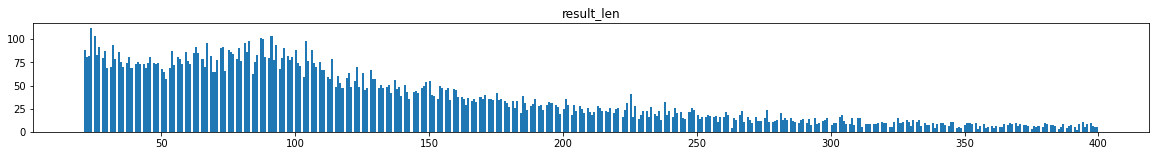

In [70]:
plt.figure(figsize = (20,2))
plt.hist(x_len, bins = 500)
plt.title('result_len')
plt.show()

## Train LdaModel

Select 10 topics

In [71]:
med_dictionary = Dictionary(sequences) #подаем список списков слов, формируем слова
med_corpus = [med_dictionary.doc2bow(text) for text in sequences] #превращаем предложение в вектор bow
numTopics=10

In [72]:
print(print_now())
start_time = time.time()
lda_med = LdaModel(med_corpus, num_topics=numTopics) #тренируем модель
print('Общее время: {:.2f}s'.format(time.time() - start_time))

2020-09-25 17:25:43


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Общее время: 15.87s


In [73]:
med_data = gensimvis.prepare(lda_med, med_corpus, med_dictionary) #подготовим объет визуальных данных по пространству топиков
pyLDAvis.display(med_data) #визуализируем данные

## Decomposition of topics by keywords

In [74]:
print(lda_med.print_topics())

[(0, '0.016*"25" + 0.016*"642" + 0.012*"581" + 0.010*"77" + 0.009*"4" + 0.009*"242" + 0.007*"138" + 0.007*"430" + 0.007*"71" + 0.007*"110"'), (1, '0.013*"138" + 0.011*"498" + 0.011*"33" + 0.011*"71" + 0.009*"371" + 0.008*"79" + 0.008*"1154" + 0.008*"699" + 0.007*"56" + 0.006*"69"'), (2, '0.016*"2048" + 0.015*"242" + 0.014*"2491" + 0.013*"4" + 0.010*"9" + 0.010*"132" + 0.009*"138" + 0.008*"62" + 0.008*"71" + 0.008*"15"'), (3, '0.028*"44" + 0.027*"9" + 0.020*"4" + 0.018*"117" + 0.015*"293" + 0.014*"500" + 0.011*"39" + 0.011*"531" + 0.011*"1154" + 0.010*"275"'), (4, '0.017*"9" + 0.012*"4" + 0.011*"3891" + 0.010*"71" + 0.009*"69" + 0.009*"25" + 0.007*"127" + 0.007*"1837" + 0.006*"2034" + 0.006*"579"'), (5, '0.017*"71" + 0.017*"4" + 0.013*"170" + 0.012*"77" + 0.012*"57" + 0.009*"140" + 0.009*"367" + 0.009*"430" + 0.008*"9" + 0.007*"500"'), (6, '0.030*"25" + 0.012*"371" + 0.012*"4" + 0.011*"222" + 0.010*"71" + 0.010*"15" + 0.009*"138" + 0.009*"9" + 0.008*"242" + 0.007*"54"'), (7, '0.055*"9" 

## Markup text by topic

In [75]:
doc_lda = lda_med[med_corpus]

In [76]:
Label=[]
for i,t in enumerate(doc_lda):
  label=t[0][0]
  p=t[0][1]
  for j in range(len(t)-1):
    if t[j+1][1]>p:
      p=t[j+1][1]
      label=t[j+1][0]
  Label.append(label)     

In [77]:
doc_lda[1]

[(1, 0.13345267),
 (2, 0.32897118),
 (5, 0.11627476),
 (6, 0.24896277),
 (9, 0.16909106)]

In [78]:
Label[1]

2

In [79]:
doc_lda[100]

[(0, 0.34066358),
 (3, 0.18231243),
 (4, 0.01708576),
 (5, 0.07414522),
 (6, 0.16353393),
 (7, 0.21905847)]

In [80]:
Label[100]

0

In [81]:
len(Label)

13613

## Distribution of phrases by topics

In [82]:
# Распределенеи фраз по топикам
c = Counter(Label)
print(c)

Counter({6: 2474, 1: 1793, 0: 1660, 9: 1439, 5: 1306, 8: 1191, 2: 1072, 3: 979, 7: 895, 4: 804})


## Transferring markup results to a dataset

Для обучения из авторазметки возьмём 6 topick про "группу крови"

In [105]:
X_train = sequences

In [106]:
Y_train = np.zeros((len(Label)), dtype='uint8')
ind_x = [l == 6 for l in Label]
Y_train[ind_x] = 1
print(Y_train.shape, Y_train)

(13613,) [0 0 0 ... 1 0 1]


In [107]:
maxWordsCount = 5000    #зададим макс.кол-во слов/индексов, учитываемое при обучении текстов 
tokenizer = Tokenizer(num_words=maxWordsCount, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(X_train)           #"скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #Вытаскиваем индексы слов для просмотра
print("Размер словаря", len(items))
print(items[:100])
print(items[-100:])

Размер словаря 58444
[('unknown', 1), ('пациент', 2), ('группа', 3), ('быть', 4), ('исследование', 5), ('уровень', 6), ('показатель', 7), ('результат', 8), ('являться', 9), ('лечение', 10), ('развитие', 11), ('метод', 12), ('случай', 13), ('анализ', 14), ('оценка', 15), ('более', 16), ('год', 17), ('возраст', 18), ('время', 19), ('нарушение', 20), ('сравнение', 21), ('изменение', 22), ('заболевание', 23), ('составить', 24), ('мочь', 25), ('снижение', 26), ('помощь', 27), ('течение', 28), ('использование', 29), ('период', 30), ('степень', 31), ('наличие', 32), ('значение', 33), ('частота', 34), ('процесс', 35), ('состояние', 36), ('система', 37), ('иметь', 38), ('число', 39), ('количество', 40), ('активность', 41), ('кровь', 42), ('критерий', 43), ('качество', 44), ('фактор', 45), ('цель', 46), ('увеличение', 47), ('женщина', 48), ('ребёнок', 49), ('проведение', 50), ('форма', 51), ('клетка', 52), ('проводиться', 53), ('операция', 54), ('терапия', 55), ('различие', 56), ('связь', 57), (

In [108]:
xTrainIndexes = tokenizer.texts_to_sequences(X_train) # обучающие тесты в индексы
X_train = pad_sequences(xTrainIndexes, maxlen=max_x_len, padding='post', truncating='post')
print(X_train.shape, X_train[0])

(13613, 400) [  46  126 4658  453   23  114  625  132   23    1  113  168   62    2
    4    1 1311  226 2053    4  837 1583  838  226    4    3   24    2
 1367    3  462  589    2   23    4    6  837    2    4    1  418   66
  300 3505   35 1638  156    1    2  418  222    4  130  132   23   74
  929   94  453   35    1 1254  453    1   38  191   21  496    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

*Здесь должна быть вставлена балансировка массивов*

In [109]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=43)

## Modelling

In [110]:
embedding_size = 200
model = Sequential()
model.add(Embedding(maxWordsCount, embedding_size))
model.add(LSTM(200)) #продвинутый RNN слой
model.add(Dense(1, activation='sigmoid')) # 0- не принадлежит классу; 1-принадлежит классу

In [111]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='Adam')

In [112]:
model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
341/341 [==============================] - 497s 1s/step - loss: 0.4794 - accuracy: 0.8161 - val_loss: 0.4720 - val_accuracy: 0.8197
Epoch 2/10
341/341 [==============================] - 495s 1s/step - loss: 0.4761 - accuracy: 0.8180 - val_loss: 0.4723 - val_accuracy: 0.8197
Epoch 3/10
341/341 [==============================] - 472s 1s/step - loss: 0.4756 - accuracy: 0.8183 - val_loss: 0.4736 - val_accuracy: 0.8197
Epoch 4/10
341/341 [==============================] - 484s 1s/step - loss: 0.4756 - accuracy: 0.8178 - val_loss: 0.4721 - val_accuracy: 0.8197
Epoch 5/10
341/341 [==============================] - 489s 1s/step - loss: 0.4756 - accuracy: 0.8179 - val_loss: 0.4728 - val_accuracy: 0.8197
Epoch 6/10
341/341 [==============================] - 498s 1s/step - loss: 0.4757 - accuracy: 0.8179 - val_loss: 0.4719 - val_accuracy: 0.8197
Epoch 7/10
341/341 [==============================] - 514s 2s/step - loss: 0.4749 - accuracy: 0.8181 - val_loss: 0.4721 - val_accuracy: 0.8197